## **Problem Statement**

**Determine the Feet and corresponding Shoe size of a person without Deep Learning, given a image clicked by the person itself.**

## **Working Aproach**


1.   Convert raw image to HSV format.
2.   Remove noise using Gaussian Blur.
3.   Run k-means clustering on preprocessed image for color based segmentation.
4.   Detect the edges in clustered image.
5.   Find contours in Edge Detection output.
6.   Generate the bounding Box to get the height/width of Paper and Feet.







## **Assumptions**



1.   Printer Paper is used as a reference (Height/Width is known and White background will help in Preprocessing).
2.   Foot should be in center, touching one edge of paper.
3.   Floor color should be different than white.
4.   Image should be clicked from top angle.
5.   Paper should be completely visible in the clicked image.





In [101]:
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage
from imutils import contours
import argparse
import imutils
import cv2
from google.colab.patches import cv2_imshow
from sklearn.cluster import KMeans
import random as rng

In [102]:
#Mount data path from drive. 

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [103]:
def preprocess(img):

    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    img = cv2.GaussianBlur(img, (9, 9), 0)
    img = img/255

    return img

In [104]:
def plotImage(img):
    
    plt.imshow(img)
    #plt.title('Clustered Image')
    plt.show()

In [105]:
def cropOrig(bRect, oimg):
    # x (Horizontal), y (Vertical Downwards) are start coordinates
    # img.shape[0] = height of image
    # img.shape[1] = width of image

    x,y,w,h = bRect

    print(x,y,w,h)
    pcropedImg = oimg[y:y+h,x:x+w]

    x1, y1, w1, h1 = 0, 0, pcropedImg.shape[1], pcropedImg.shape[0]

    y2 = int(h1/10)

    x2 = int(w1/10)

    crop1 = pcropedImg[y1+y2:h1-y2,x1+x2:w1-x2]

    #cv2_imshow(crop1)

    ix, iy, iw, ih = x+x2, y+y2, crop1.shape[1], crop1.shape[0]

    croppedImg = oimg[iy:iy+ih,ix:ix+iw]

    return croppedImg, pcropedImg


In [106]:
def overlayImage(croppedImg, pcropedImg):


    x1, y1, w1, h1 = 0, 0, pcropedImg.shape[1], pcropedImg.shape[0]

    y2 = int(h1/10)

    x2 = int(w1/10)

    new_image = np.zeros((pcropedImg.shape[0], pcropedImg.shape[1], 3), np.uint8)
    new_image[:, 0:pcropedImg.shape[1]] = (255, 0, 0) # (B, G, R)

    new_image[ y1+y2:y1+y2+croppedImg.shape[0], x1+x2:x1+x2+croppedImg.shape[1]] = croppedImg

    return new_image


In [107]:
def kMeans_cluster(img):

    # For clustering the image using k-means, we first need to convert it into a 2-dimensional array
    # (H*W, N) N is channel = 3
    image_2D = img.reshape(img.shape[0]*img.shape[1], img.shape[2])

    # tweak the cluster size and see what happens to the Output
    kmeans = KMeans(n_clusters=2, random_state=0).fit(image_2D)
    clustOut = kmeans.cluster_centers_[kmeans.labels_]

    # Reshape back the image from 2D to 3D image
    clustered_3D = clustOut.reshape(img.shape[0], img.shape[1], img.shape[2])

    clusteredImg = np.uint8(clustered_3D*255)

    return clusteredImg


In [108]:
def getBoundingBox(img):

    contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    #print(len(contours))
    contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)
    
    

    contours_poly = [None]*len(contours)
    boundRect = [None]*len(contours)

    for i, c in enumerate(contours):
        contours_poly[i] = cv2.approxPolyDP(c, 3, True)
        boundRect[i] = cv2.boundingRect(contours_poly[i])

    
    return boundRect, contours, contours_poly, img


In [109]:
def drawCnt(bRect, contours, cntPoly, img):

    drawing = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)   


    paperbb = bRect

    for i in range(len(contours)):
      color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
      cv2.drawContours(drawing, cntPoly, i, color)
      #cv2.rectangle(drawing, (int(boundRect[i][0]), int(boundRect[i][1])), \
              #(int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)
    cv2.rectangle(drawing, (int(paperbb[0]), int(paperbb[1])), \
              (int(paperbb[0]+paperbb[2]), int(paperbb[1]+paperbb[3])), color, 2)
    
    return drawing

In [110]:
def edgeDetection(clusteredImage):
  #gray = cv2.cvtColor(hsvImage, cv2.COLOR_BGR2GRAY)
  edged1 = cv2.Canny(clusteredImage, 0, 255)
  edged = cv2.dilate(edged1, None, iterations=1)
  edged = cv2.erode(edged, None, iterations=1)
  return edged

In [111]:
oimg = imread('https://sv1.picz.in.th/images/2021/10/10/u4K8QD.jpg')

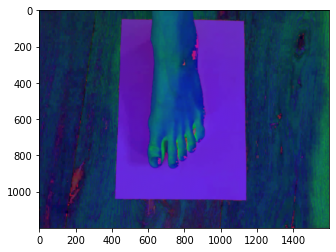

In [112]:
preprocessedOimg = preprocess(oimg)
plotImage(preprocessedOimg)

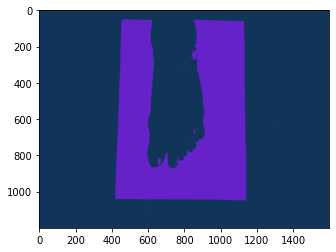

In [113]:
clusteredImg = kMeans_cluster(preprocessedOimg)
plotImage(clusteredImg)

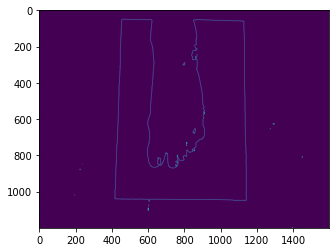

In [114]:
edgedImg = edgeDetection(clusteredImg)
plotImage(edgedImg)

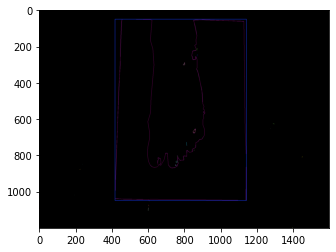

In [115]:
#getting paper bounding box

boundRect, contours, contours_poly, img = getBoundingBox(edgedImg)
pdraw = drawCnt(boundRect[1], contours, contours_poly, img)
plotImage(pdraw)


419 50 725 998


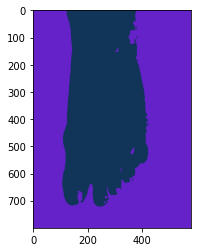

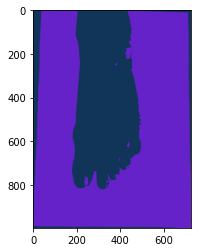

In [116]:
croppedImg, pcropedImg = cropOrig(boundRect[1], clusteredImg)
plotImage(croppedImg)
plotImage(pcropedImg)


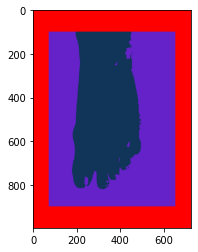

In [117]:
newImg = overlayImage(croppedImg, pcropedImg)
plotImage(newImg)

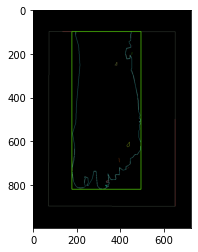

In [118]:

fedged = edgeDetection(newImg)
fboundRect, fcnt, fcntpoly, fimg = getBoundingBox(fedged)
fdraw = drawCnt(fboundRect[2], fcnt, fcntpoly, fimg)
plotImage(fdraw)

In [119]:
def calcFeetSize(pcropedImg, fboundRect):
  x1, y1, w1, h1 = 0, 0, pcropedImg.shape[1], pcropedImg.shape[0]

  y2 = int(h1/10)

  x2 = int(w1/10)

  fh = y2 + fboundRect[2][3]
  fw = x2 + fboundRect[2][2]
  ph = pcropedImg.shape[0]
  pw = pcropedImg.shape[1]

  print("Feet height: ", fh)
  print("Feet Width: ", fw)

  print("Paper height: ", ph)
  print("Paper Width: ", pw)

  opw = 210
  oph = 297

  ofs = 0.0

  if fw>fh:
    ofs = (oph/pw)*fw
  else :
    ofs = (oph/ph)*fh



  return ofs


In [120]:
print("feet size (cm): ", calcFeetSize(pcropedImg, fboundRect)/10)

Feet height:  821
Feet Width:  389
Paper height:  998
Paper Width:  725
feet size (cm):  24.43256513026052
